In [16]:
# load in R packages 
library(ggplot2)
library(ggcorrplot)
library(Rmisc)
library(reshape2)
library(repr)
library(pracma)
library(matlab)
library(gridExtra)

# parameters to change

In [2]:
# strength of drift 
scale_drift = 0.4 # scaling parameter (not used if inputting manual drift)

# strength of semantic + episodic route 
sem = 0.3
episodic = 0.7

# normalize
sem_weight = sem/(episodic+sem)
episodic_weight = episodic/(episodic+sem)

# reward sequence

In [3]:
pres_indices = sample(10) # random sample

# high RPE within sequence (first outcome is "reward expectation" at 0)
# sequence = c(0, 54, 57, 56, 53, 55, 7, 5, 4, 6, 3) # initial expectation is 0

# primacy (first outcome is "reward expectation" at 50)
sequence = c(50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45)

# dynamic beta 
absPE = array(data=0,dim=c(length(pres_indices),1))

# take absolute difference of previous reward with current reward
# (first "prediction error" is reward - initial expectation)
for (seq in 1:length(sequence)-1){
    absPE[seq] = abs(sequence[seq]-sequence[seq+1])
    }

# take absolute value of z-scored absPE and multiply by scaling parameter 
B_encD = abs(scale(absPE))*scale_drift

B_encD <- ifelse(B_encD>1,1,B_encD) # if it's over 1, make it 1

## MANUAL DRIFT (comment out if using above or stable drift)

B_encD = c(1,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75)

In [4]:
# SET PARAMETERS

# for creating the network
gamma_fc = 0.581 # relative strength of pre-existing associations on connections feature-context
eye_fc = 1 - gamma_fc # if items are rep as orthonormal vectors, identity matrix ("eye")
eye_cf = 0

# during encoding
B_enc = 0.745 # vector of context integration rate at encoding, dynamic alternative above 
lrate_fc_enc = gamma_fc # feature-to-context during encoding
lrate_cf_enc = 1 # context-to-feature during encoding

# during recall 
B_rec = 0.36 # vector of context integration at recall
lrate_fc_rec = 0 # feature-to-context during recall
lrate_cf_rec = 0 # context-to-feature during recall
thresh = 1 # threshold for an accumulating element to win the decision competition (fixed at 1)
rec_time = 90000 # max recall process (interpreted as 90 seconds)
dt = 100 # time constant on decision process
L = 0.375 # lateral inhibition between units in decision competition 
K = 0.091 # decay rate for the accumulating elements in decision competition 
eta = 0.3699 # standard deviation of gaussian noise term in decision competition 
tau = 413 # time constant in decision competition 

n_sims = 1000 # number of simulations 
recall_sims = array(data=0,dim=c(length(pres_indices),n_sims))
times_sims = array(data=0,dim=c(length(pres_indices),n_sims))

In [5]:
# create "semantic" matrix 

# each item has an activation of 1 (and to no other units)
sem_mat = diag(length(pres_indices)) 

In [6]:
for (sims in 1:n_sims){

    # NETWORK

    # initialize the features and context layers
    net.f = array(data=0,dim=c(length(pres_indices),1))
    net.c = array(data=0,dim=c(length(pres_indices),1))

    # learning rate matrices 
    net.lrate_fc = array(data=0,dim=c(length(pres_indices),length(pres_indices)))
    net.lrate_cf = array(data=0,dim=c(length(pres_indices),length(pres_indices)))

    # the lrate matrices
    net.lrate_fc_enc = array(data=lrate_fc_enc,dim=c(length(pres_indices),length(pres_indices)))
    net.lrate_cf_enc = array(data=lrate_cf_enc,dim=c(length(pres_indices),length(pres_indices)))
    net.lrate_fc_rec = array(data=lrate_fc_rec,dim=c(length(pres_indices),length(pres_indices)))
    net.lrate_cf_rec = array(data=lrate_cf_rec,dim=c(length(pres_indices),length(pres_indices)))

    net.w_fc = diag(length(net.c)) * eye_fc # m_fc eye() creates identity matrices
    net.w_cf = diag(length(net.f)) * eye_cf # m_cf zero
    net.weights = array(data=0,dim=c(length(pres_indices),length(pres_indices)))
    
    # ENCODING

    net.idx = seq(1,length(pres_indices))

    for (item in 1:length(pres_indices)){

      # present item 
      feature.idx = pres_indices[item]

      # activates the indexed feature (each item activates one element)
      net.f = array(data=0,dim=c(length(pres_indices),1))
      net.f[feature.idx] = 1

      # update context reprsentations 
      net.c_in = net.w_fc %*% net.f

      # normalize vector 
      vec = net.c_in 
      denom_vec = as.vector(sqrt(t(vec) %*% vec))
      norm_vec = vec / denom_vec
      net.c_in = norm_vec

      # advance context
      c_in = net.c_in
      c = net.c      
        
      # set dynamic or stable drift   
      B = B_encD[item] # beta at encoding for dynamic
      # B = B_enc # beta at encoding if stable 

      rho = sqrt(1+(B^2)*((dot(c,c_in)^2)-1)) - B*dot(c,c_in)
      updated_c = rho*c + B*c_in
      net.c = updated_c

      # determine current learning rate 
      lrate_fc = net.lrate_fc_enc
      lrate_cf = net.lrate_cf_enc 

      # update weights

      # w_fc
      delta = (net.c %*% t(net.f)) * lrate_fc
      net.w_fc = net.w_fc + delta

      # w_cf
      delta = (net.f %*% t(net.c)) * lrate_cf
      net.w_cf = net.w_cf + delta
    }

    # RECALL 

    # set up 
    recalls = array(data=0,dim=c(length(pres_indices),1))
    times = array(data=0,dim=c(length(pres_indices),1))

    rec_time = 90000
    time_passed = 0
    recall_count = 0

    retrieved = array(data=0,dim=c(length(pres_indices),1))
    thresholds = array(data=1,dim=c(length(pres_indices),1))

    # semantic + episodic routes 
      net.weights = episodic_weight*net.w_cf + sem_weight*sem_mat
    
    # GO!!!
    
    while (time_passed < rec_time) {
        
      # input to the feature layer, from last context cue 
      f_in = net.weights %*% net.c

      # set max number of cycles
      max_cycles = (rec_time - time_passed) / dt

      # for noise error standard deviation
      dt_tau = dt/tau 
      sq_dt_tau = sqrt(dt_tau)

      # noise matrix
      noise = matrix(rnorm(length(pres_indices)*max_cycles,mean=0,sd=eta*sq_dt_tau),length(pres_indices),max_cycles)
      eyeI = !diag(length(pres_indices))
      lmat = eyeI * L

      ncycles = size(noise,2)
      inds = 1:length(pres_indices)

      crossed = 0

      x = array(data=0,dim=c(length(pres_indices),1))

      K = array(data=1,dim=c(length(pres_indices),1))*K

      i = 1

      # ACCUMULATORS CYCLING
      while (i < ncycles && crossed == 0) {

        # the lateral inhibition felt by each unit 
        lx = lmat %*% x

        # the activity leaking from each unit 
        kx = K * x

        # change in each accumulator 
        x = x + ((f_in - kx - lx) * dt_tau + (noise[,i]))
        x[x<0] = 0

        # reset retrieved values, allow them to compete but prevent from accumulating
        reset_these = retrieved & (x >= thresholds)
        x[reset_these] = 0.95*thresholds[reset_these]

        # retrieved items cannot be repeated 
        retrievable = !retrieved 

        # determine whether any items have crossed thresholds
        crossed = 0
        if (any(x[retrievable] >= thresholds[retrievable])) {
          crossed = 1
          temp_win = x[retrievable] >= thresholds[retrievable]
          temp_ind = inds[retrievable]
          winners = temp_ind[temp_win]

          # if there is a tie, random tiebreak 
          if (length(winners) > 1){
            winners = sample(winners,1)
          }

          winner_position = which(pres_indices==winners)
        } # end retrieved

        i = i + 1 
      } # i ncycles 

      # calculate the amount of elapsed time 
      time = i * dt

      time_passed = time_passed + time

      # reactivate item if there has been a retrieval 
      if (crossed == 1){

        # activate the retrieved feature
        net.f = array(data=0,dim=c(length(pres_indices),1))
        net.f[winners] = 1

        # update context reprsentations 
        net.c_in = net.w_fc %*% net.f

        # normalize vector 
        vec = net.c_in 
        denom_vec = as.vector(sqrt(t(vec) %*% vec))
        norm_vec = vec / denom_vec
        net.c_in = norm_vec

        # advance context
        c_in = net.c_in
        c = net.c
        B = B_rec # beta at retrieval

        rho = sqrt(1+(B^2)*((dot(c,c_in)^2)-1)) - B*dot(c,c_in)
        updated_c = rho*c + B*c_in
        net.c = updated_c

        # determine current learning rate 
        lrate_fc = net.lrate_fc_rec
        lrate_cf = net.lrate_cf_rec

        # w_fc
        delta = (net.c %*% t(net.f)) * lrate_fc
        net.w_fc = net.w_fc + delta

        # w_cf
        delta = (net.f %*% t(net.c)) * lrate_cf
        net.w_cf = net.w_cf + delta

        # record data
        recall_count = recall_count + 1
        recalls[recall_count,1] = winner_position 
        times[recall_count,1] = time_passed

        # update retrieved vector
        retrieved[winners] = 1

      } # end if crossed

    } # rec_time

      recall_sims[,sims] = recalls
      times_sims[,sims] = times
  
} # end sims

# serial position curve

In [7]:
# calculate the total proportion of recall given the serial position 
position<-as.data.frame(seq(1,length(pres_indices)))
colnames(position)<-c("position")

numSums<-array(data=0,dim=c(length(pres_indices),1))
      
for (numSum in 1:length(numSums)){
    numSums[numSum] = sum(sum(recall_sims==numSum))
}
      
recall <- numSums/n_sims

prop_recall<-cbind(position,recall)

prop_recall

position,recall
1,0.011
2,0.015
3,0.026
4,0.042
5,0.110
6,0.236
7,0.488
8,0.915
9,0.999
10,1.000


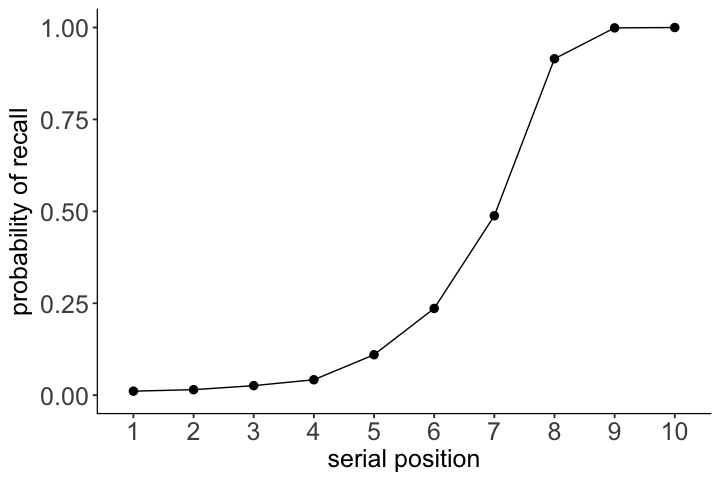

In [8]:
# plot recall success as a function of serial position 
options(repr.plot.width=6,repr.plot.height=4)

ggplot(data=prop_recall,aes(x=as.factor(position),y=recall))+geom_point(size=2)+geom_line(group=1,size=0.4)+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black"),axis.title = element_text(size=15),axis.text = element_text(size=15),legend.text=element_text(size=20),legend.title=element_text(size=20))+
    xlab("serial position")+ylab("probability of recall")+ylim(0,1)

# first recall probability

In [9]:
# determine the proportion of "first recall" items as a function of serial position 
first_recall<-recall_sims[1,]
first_recall_table<-as.data.frame(table(first_recall))
first_recall_table$prop<-first_recall_table$Freq/n_sims
colnames(first_recall_table)<-c("position","freq","prop")
first_recall_table

position,freq,prop
1,1,0.001
2,1,0.001
4,1,0.001
5,3,0.003
6,2,0.002
7,8,0.008
8,40,0.040
9,168,0.168
10,776,0.776


Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

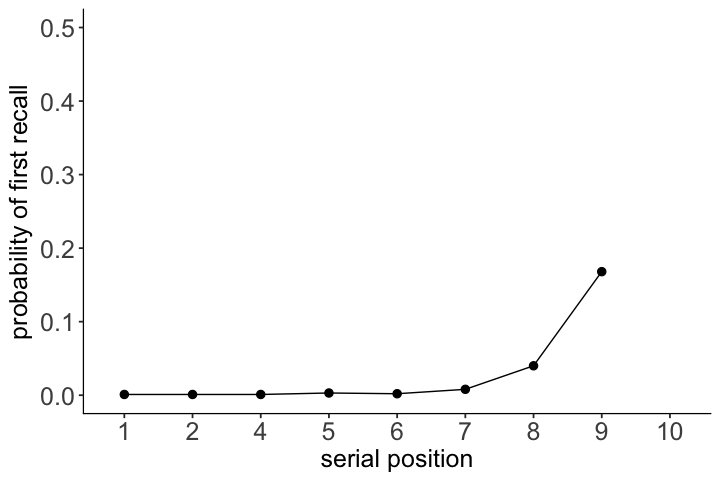

In [10]:
# plot first recall proportion as a function of serial position 
options(repr.plot.width=6,repr.plot.height=4)

ggplot(data=first_recall_table,aes(x=position,y=prop))+geom_point(size=2)+geom_line(group=1,size=0.4)+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black"),axis.title = element_text(size=15),axis.text = element_text(size=15),legend.text=element_text(size=20),legend.title=element_text(size=20))+
    xlab("serial position")+ylab("probability of first recall")+ylim(0,0.5)

In [11]:
# re-organize weight matrices for plotting (so as to view them by serial position)
net.w_fc_inorder = net.w_fc[,pres_indices]
net.w_cf_inorder = net.w_cf[pres_indices,]

In [12]:
# set up weight matrices plots
long_fc<-melt(net.w_fc_inorder)
long_cf<-melt(t(net.w_cf_inorder))

p1<-ggplot(long_fc, aes(x = as.factor(Var2), y = as.factor(Var1))) + 
  geom_raster(aes(fill=value)) + geom_tile(aes(fill=value),color="grey50",size=0.2)+
  scale_fill_gradient(low="blue", high="orange") +
  labs(title="feature to context weight matrix",x="serial position",y="") +
  theme(plot.title=element_text(size=20),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black"),axis.title = element_text(size=25),axis.text = element_text(size=15),legend.text=element_text(size=12),legend.title=element_text(size=20))
 
p2<-ggplot(long_cf, aes(x = as.factor(Var2), y = as.factor(Var1))) + 
  geom_raster(aes(fill=value)) + geom_tile(aes(fill=value),color="grey50",size=0.2)+
  scale_fill_gradient(low="white", high="red") +
  labs(title="context to feature weight matrix",x="serial position",y="") +
  theme(plot.title=element_text(size=20),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black"),axis.title = element_text(size=25),axis.text = element_text(size=15),legend.text=element_text(size=12),legend.title=element_text(size=20))

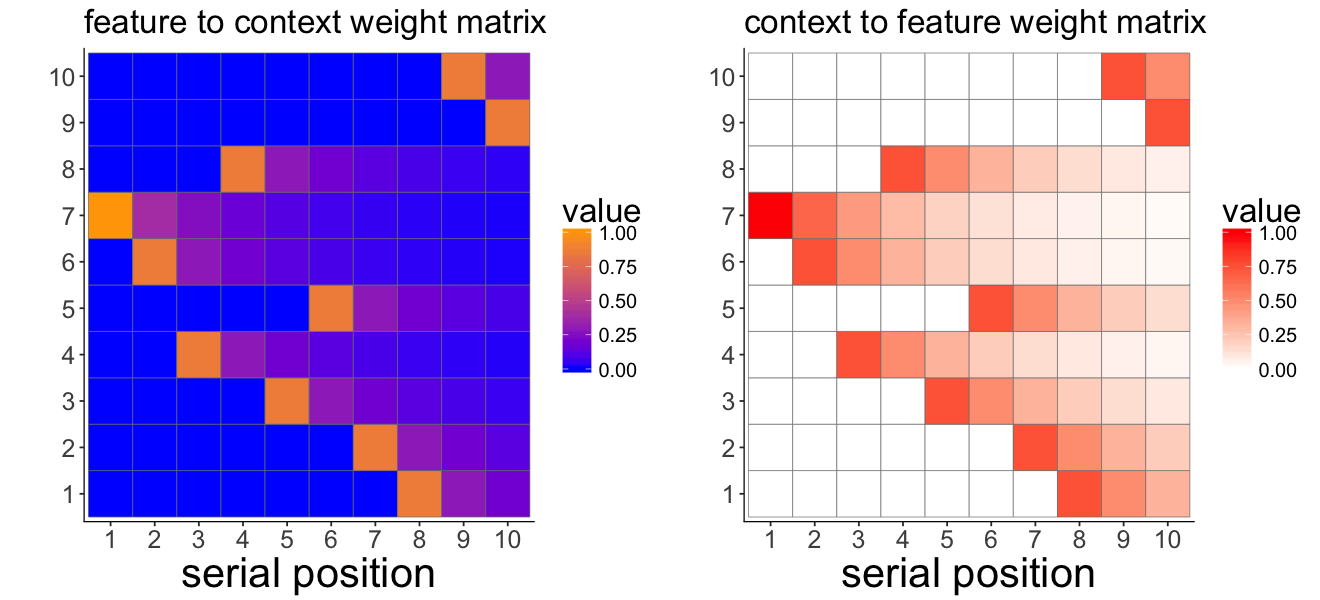

In [13]:
# plot weight matrices
options(repr.plot.width=11,repr.plot.height=5)

grid.arrange(p1,p2,ncol=2)

In [17]:
# set up correlation plots
corr_fc = cor(net.w_fc_inorder)
corr_cf = cor(t(net.w_cf_inorder))

corr_fc<-melt(corr_fc)
corr_cf<-melt(corr_cf)

p1<-ggplot(corr_fc, aes(x = as.factor(Var2), y = as.factor(Var1))) + 
  geom_raster(aes(fill=value)) + geom_tile(aes(fill=value),color="grey50",size=0.2)+
  scale_fill_gradient(low="#6600ff",high="orange") +
  labs(title="feature to context weight matrix",x="serial position",y="") +
  theme(plot.title=element_text(size=20),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black"),axis.title = element_text(size=25),axis.text = element_text(size=15),legend.text=element_text(size=12),legend.title=element_text(size=20))
 
p2<-ggplot(corr_cf, aes(x = as.factor(Var2), y = as.factor(Var1))) + 
  geom_raster(aes(fill=value)) + geom_tile(aes(fill=value),color="grey50",size=0.2)+
  scale_fill_gradient(low="blue",high="orange") +
  labs(title="context to feature weight matrix",x="serial position",y="") +
  theme(plot.title=element_text(size=20),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), axis.line.x = element_line(colour = "black"), axis.line.y = element_line(colour = "black"),axis.title = element_text(size=25),axis.text = element_text(size=15),legend.text=element_text(size=12),legend.title=element_text(size=20))

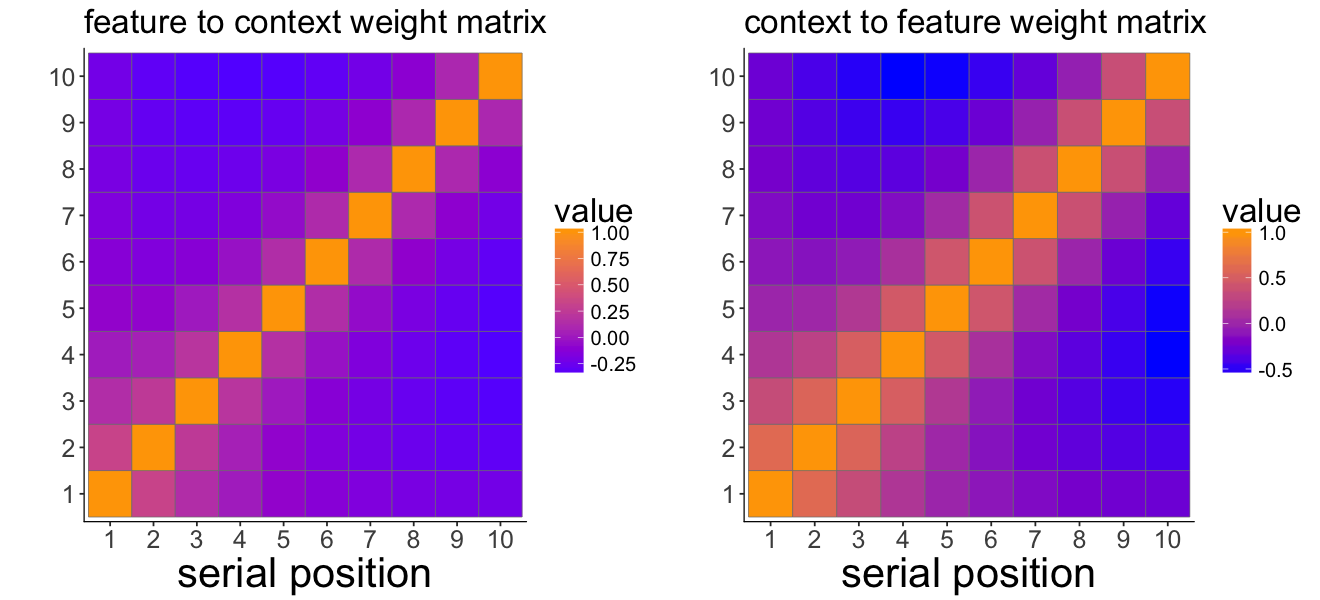

In [18]:
# plot correlations
options(repr.plot.width=11,repr.plot.height=5)

grid.arrange(p1,p2,ncol=2)